In [1]:
# |default_exp eigen_decomposition
# |export
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from typing import Tuple

# 1.6a: 本征值分解 Eigenvalue Decomposition

*   矩阵分解可被简单理解为“在一定约束条件下，将一个矩阵化成多个矩阵乘积的过程”。
*   **本征值分解数学形式：** $M = U\Lambda U^{\dagger}$ (其中 $\dagger$ 表示取转置复共轭)，即 $M_{ac} = \sum_{b} U_{ab}\Lambda_{bb}U^{*}_{cb}$。
*   **约束条件：**（1）变换矩阵的幺正性：$U^{\dagger}U = UU^{\dagger} = I$ ；(2) $\Lambda$为对角矩阵。

![eigenvalue-decomposition-tensor-network](images/eigenvalue_decomposition_tensor_network.png)

注意对角矩阵用菱形或者实心圆点表示，两条线段其实代表同一个 index

## 本征方程的解

*   本征值分解给出**本征方程**的解，即归一化向量$v$，满足 $Mv = \gamma v$
*   $U$ 的列向量给出本征方程的解，$\Lambda$的对角元给出本征值，满足 $MU_{:,n} = \Lambda_{n,n}U_{:,n}$
*   并不是任意矩阵都存在本征值分解！
*   厄密矩阵（$M = M^{\dagger}$）一定存在本征值分解，且本征值为实数。

### 本征方程的应用
* $M$ 可以是动力学的描述，$v$ 可以是动力学的一个稳定点
* $M$ 可以是一个旋转算符，例如旋转 180 度，那么直线可以理解为是这个旋转算符的本征方程的解




In [2]:
# |export
def rand_hermitian_matrix(dim: int) -> torch.Tensor:
    """
    Generate a random Hermitian matrix of given dimension.

    Args:
        dim (int): Dimension of the matrix.
    Returns:
        torch.Tensor: A Hermitian matrix of the specified dimension.
    """
    H = torch.randn(dim, dim, dtype=torch.complex64)
    H = H + H.conj().t()
    return H


# |export
def rand_real_symmetric_matrix(dim: int) -> torch.Tensor:
    """
    Generate a random real symmetric matrix of given dimension.

    Args:
        dim (int): Dimension of the matrix.
    Returns:
        torch.Tensor: A real symmetric matrix of the specified dimension.
    """
    mat = torch.randn(dim, dim, dtype=torch.float32)
    mat = (mat + mat.t()) / 2
    return mat

In [3]:
H = rand_hermitian_matrix(3)
print(f"Random Hermitian Matrix:\n{H}")

# To decompose a *Hermitian* matrix, use the `eigh` function
eigenvalues, u = torch.linalg.eigh(H)
print(f"Eigenvalues:\n{eigenvalues}")
print(f"EigenVectors:\n{u}")

reconstructed_H = u @ torch.diag(eigenvalues.to(torch.complex64)) @ u.conj().t()
error = (H - reconstructed_H).norm()
print(f"Error:\n{error}")

Random Hermitian Matrix:
tensor([[ 2.2010+0.0000j,  0.7201-0.7103j, -0.1388-0.4911j],
        [ 0.7201+0.7103j, -0.4408+0.0000j, -1.1326+0.8639j],
        [-0.1388+0.4911j, -1.1326-0.8639j,  1.5536+0.0000j]])
Eigenvalues:
tensor([-1.5185,  2.1977,  2.6347])
EigenVectors:
tensor([[ 0.2882+0.0000j, -0.4505+0.0000j,  0.8450+0.0000j],
        [-0.5574-0.6425j,  0.2690-0.2988j,  0.3336+0.0598j],
        [-0.0118-0.4397j, -0.7768-0.1789j, -0.4101+0.0546j]])
Error:
5.086078544991324e-07


In [4]:
N = 1
# To test eigenvalue decomposition
v1 = eigenvalues[N] * u[:, N]
v2 = H @ u[:, N]
assert v1.allclose(v2)

## 本征值分解对应的优化问题

*   **本征值分解对应的优化问题**：求解归一化向量，满足 $\max_{|v|=1}(v^\dagger Mv)$，即
    * $v$ 要保证是单位向量，同时最大化 $v^\dagger Mv$
*   上述问题的解为 **M** 的最大本征值对应的 **本征向量**，$v^\dagger Mv$ 的值给出 **最大本征值**
*   考虑建立如下损失函数：
    $L = -\frac{v^\dagger Mv}{v^\dagger v}$
    * $v$ 不限制长度，所以要手动归一化
*   优化 $v$ 实现 $L$ 的极小化，即可得到 **M** 的最大本征值及对应的本征向量

### 证明
Presumption: We don't consider eigenvalue degeneration, so there's only one max eigenvalue.

Since $U$ is unitary, its columns are orthonormal so they can be basis vectors. Then we can express $v$ as a linear combination of the columns of $U$:
$$
v = Uc
$$
We also have that $v$ is unit vector, so
$$
v^\dagger v = c^\dagger U^\dagger Uc = c^\dagger c = 1
$$
Therefore, $c$ is a unit vector as well.

We now have
$$
v^\dagger M v = c^\dagger U^\dagger M U c = c^\dagger U^\dagger U \Lambda U^\dagger U c = c^\dagger \Lambda  c = \sum_k c_k^\dagger \Lambda_{kk} c_k
$$

Since $c$ is a unit vector  $\sum_k c_k^\dagger c_k = 1$, so the result can be considered as the weighted sum of all eigenvalues.

If and only if
$$
c_k = \left\{
\begin{array}{ll}
      1 & \text{if}\ k=0 \\
      0 & \text{otherwise}\\
\end{array}
\right.
$$
then we have the max value.


### 优化例子

In [5]:
dim = 8
lr = 2e-2
it_num = 300

# Generate a random real symmetric matrix (subset of Hermitian matrices)
mat = rand_real_symmetric_matrix(8)

v = torch.randn(dim, dtype=torch.float32, requires_grad=True)
adam = torch.optim.Adam([v], lr=lr)
losses = torch.zeros(it_num, dtype=torch.float32)

for t in tqdm(range(it_num)):
    # left out conjugate since v is real
    loss = -torch.einsum("a,ab,b", v, mat, v) / v.dot(v)
    loss.backward()
    adam.step()
    adam.zero_grad()
    losses[t] = loss.detach()

  0%|          | 0/300 [00:00<?, ?it/s]

In [6]:
found_max_eigenvalues = -losses
ref_eigenvalues = torch.linalg.eigvalsh(mat)
ref_max_eigenvalue = ref_eigenvalues.max()

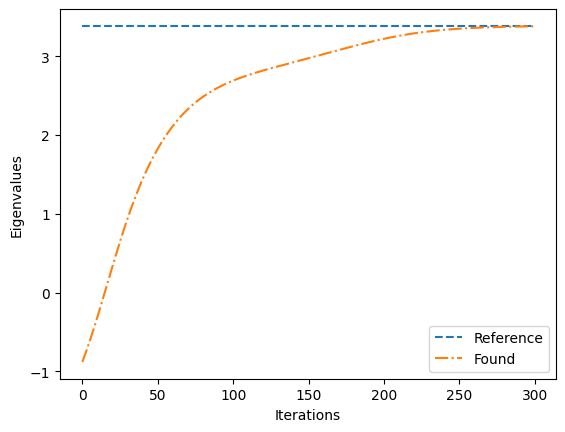

In [7]:
# plot
iterations = range(it_num)
fig, ax = plt.subplots()
ax.plot(iterations, torch.ones(it_num) * ref_max_eigenvalue, linestyle="--", label="Reference")
ax.plot(iterations, found_max_eigenvalues, linestyle="-.", label="Found")
ax.set_xlabel("Iterations")
ax.set_ylabel("Eigenvalues")
ax.legend()

### 任意线性映射的本征值分解

*   **任何线性映射**均可定义本征方程
    $f(v) = \gamma v$
*   使用scipy中的**线性算子 (LinearOperator)** 求解；
*   该方法对于复杂线性映射的处理十分有用，比如说一些线性映射的参数很少，但是如果写矩阵 $M$ 出来的话很麻烦或者很大，那么可以直接用线性算子来进行计算

In [8]:
from scipy.sparse.linalg import eigsh, LinearOperator

dim = 8
# M is a sparse real symmetric matrix, representing a linear map that has a few parameters compared to the size of the matrix
M = torch.eye(dim, dtype=torch.float32)
M[0, 7] = 1.0
M[7, 0] = 1.0

# Get the max eigenvalue with PyTorch
eigenvalues = torch.linalg.eigvalsh(M)
max_eigenvalue_torch = eigenvalues.max()

# Get the max eigenvalue with scipy
M_scipy = M.numpy()
eigenvalues, _ = eigsh(M_scipy, k=1, which="LA")
max_eigenvalue_scipy = eigenvalues[0]

# Get the max eigenvalue with LinearOperator
M2 = LinearOperator(shape=M_scipy.shape, matvec=lambda v: M_scipy @ v)
eigenvalues, _ = eigsh(M2, k=1, which="LA")
max_eigenvalue_linear_operator = eigenvalues[0]

print(
    f"torch: {max_eigenvalue_torch}, scipy: {max_eigenvalue_scipy}, LinearOperator: {max_eigenvalue_linear_operator}"
)

torch: 2.0, scipy: 2.0, LinearOperator: 2.0


# 1.6b: 本征方程的幂方法

**投影法**，用于求解 Hermitian Matrix 某个特定的本征值和本征向量

> 和 [5.1](5-1.ipynb) 里的虚时间演化算法有密切关系


* **定义投影矩阵**: $\tau$ 一般取为一个小量；投影矩阵有不同的定义方法，求的是不同的本征向量，具体看证明
    * $\rho = e^{-\tau H}$
    * $\rho = e^{\tau H}$
    * $\rho = e^{\tau H^2}$
    * $\rho = e^{-\tau H^2}$
* $\rho$ 和 $H$ 具有相同的本征向量，本征值间为指数关系$e^{-\tau\Gamma}$，证明：
  假设 $H$ is Hermitian，那么用泰勒展开得

  $\rho = \sum_{n=0}^{\infty} \frac{(-\tau)^n}{n!} H^n = \sum_{n=0}^{\infty} \frac{(-\tau)^n}{n!} (U\Gamma U^{\dagger})^n = U (\sum_{n=0}^{\infty} \frac{(-\tau)^n}{n!} \Gamma^n) U^{\dagger}$

  $\rho$ 的本征值为 $\sum_{n=0}^{\infty} \frac{(-\tau)^n}{n!} \Gamma^n = e^{-\tau \Gamma}$
* 注意：$\rho$ 里的每个元素不是从 $H$ 的元素的简单指数，看上面的泰勒展开就知道了
* 投影属性：$\lim_{m\to\infty}\rho^m v = C U_{:,0}$, $C$ 是一个常数
    * 证明：TODO

## 算法
根据投影属性，可以做的是：
1. 随机生成一个 $v$，不断把 $\rho$ 和 $v$ 相乘，直到数值比较稳定
2. 这个时候我们得到 $C U_{:,0}$, $C$ 是一个常数，那么只要单位化就可以得到本征向量 $u$
3. 因为有 $M u = \gamma u$，同时乘上 $u^\dagger$ 得 $u^\dagger M u = u^\dagger \gamma u = \gamma$

这个算法的效率比 PyTorch, SciPy 里的低很多（对于矩阵来说），但是在张量网络的计算里比较有用


In [9]:
import tensor_network.setup_ref_code_import as _
from Library.ExampleFun import eigs_power as eigs_power_ref

In [10]:
# |export
def eigs_power(mat: torch.Tensor, which: str, v0=None) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    ‘LM’ : Largest (in magnitude) eigenvalues.
    ‘SM’ : Smallest (in magnitude) eigenvalues.
    ‘LA’ : Largest (algebraic) eigenvalues.
    ‘SA’ : Smallest (algebraic) eigenvalues.

    Args:
        mat (torch.Tensor): Input matrix (real symmetric).
        which (str): Which eigenvalue to compute ('la', 'sa', 'lm', 'sm').
        v0 (torch.Tensor, optional): Initial vector. If None, a random vector is generated.
    Returns:
        (torch.Tensor, torch.Tensor): The computed eigenvalue and corresponding eigenvector.
    """
    which = which.lower()
    H = mat
    assert which in ["la", "sa", "lm", "sm"]
    assert H.allclose(H.t())
    assert len(H.shape) == 2

    TAU = 0.01
    if which == "la":
        rho = torch.matrix_exp(TAU * H)
    elif which == "lm":
        rho = torch.matrix_exp(TAU * torch.matrix_power(H, 2))
    elif which == "sa":
        rho = torch.matrix_exp(-TAU * H)
    elif which == "sm":
        rho = torch.matrix_exp(-TAU * torch.matrix_power(H, 2))
    else:
        raise NotImplementedError()

    ITER_NUM = 2000
    TOLERANCE = 1e-14
    if v0 is None:
        v = torch.randn(H.shape[1], dtype=H.dtype)
        v = v / v.norm()
    else:
        v = v0

    norm = 1.0
    for _ in tqdm(range(ITER_NUM)):
        v_next = rho @ v
        norm = v_next.norm()
        v_next /= norm
        diff = (v_next - v).norm()
        if diff < TOLERANCE:
            break
        v = v_next

    scaled_eigenvector = H.matmul(v)  # eigenvalue * eigenvector
    # correct sign due to squaring
    sign = torch.sign(v.dot(scaled_eigenvector))

    eigenvector = scaled_eigenvector / scaled_eigenvector.norm()
    if which == "la":
        eigenvalue = torch.log(norm) / TAU
        # same as `scaled_eigenvector.norm()`
        return eigenvalue, eigenvector
    elif which == "sa":
        eigenvalue = -torch.log(norm) / TAU
        # same as `scaled_eigenvector.norm()`
        return eigenvalue, eigenvector
    elif which == "lm":
        eigenvalue = sign * torch.sqrt(torch.log(norm) / TAU)
        # same as `sign * scaled_eigenvector.norm()`
        return eigenvalue, eigenvector
    elif which == "sm":
        # same as `sign * scaled_eigenvector.norm()`
        eigenvalue = sign * torch.sqrt(-torch.log(norm) / TAU)
        return eigenvalue, eigenvector

In [11]:
# instrumentation for debugging

from dowhen import do

new_instructions = """
print(f"which: {which}")
if which == "la":
    eigenvalue1 = scaled_eigenvector.norm()
    assert torch.isclose(eigenvalue1, eigenvalue, atol=1e-5), f"eigenvalue1: {eigenvalue1}, eigenvalue: {eigenvalue}"
elif which == "sa":
    eigenvalue1 = -scaled_eigenvector.norm()
    assert torch.isclose(eigenvalue1, eigenvalue, atol=1e-5), f"eigenvalue1: {eigenvalue1}, eigenvalue: {eigenvalue}"
elif which == "lm":
    eigenvalue1 = sign * (scaled_eigenvector.norm()) 
    assert torch.isclose(eigenvalue1, eigenvalue, atol=1e-5), f"eigenvalue1: {eigenvalue1}, eigenvalue: {eigenvalue}"
elif which == "sm":
    eigenvalue1 = sign * (scaled_eigenvector.norm())
    assert torch.isclose(eigenvalue1, eigenvalue, atol=1e-5), f"eigenvalue1: {eigenvalue1}, eigenvalue: {eigenvalue}"
"""

# execute additional new instructions when before `eigs_power` returns
do(new_instructions).when(eigs_power, "return")

In [14]:
for mode in ["la", "sa", "lm", "sm"]:
    mat = rand_real_symmetric_matrix(8)
    eigenvalue, eigenvector = eigs_power(mat, which=mode, v0=v)
    eigenvalue_ref, eigenvector_ref = eigs_power_ref(mat, which=mode, v0=v)
    assert eigenvalue.allclose(eigenvalue_ref), f"{mode} eigenvalue error"
    # It's okay if eigenvectors sign is flipped, since $U^\dagger \Lambda U = (-U^\dagger) \Lambda (-U)$
    assert torch.allclose(eigenvector, eigenvector_ref) or torch.allclose(
        -eigenvector, eigenvector_ref
    ), f"{mode} eigenvector error, ref: {eigenvector_ref}, mine: {eigenvector}"

  0%|          | 0/2000 [00:00<?, ?it/s]

which: la
which: la
which: la


  0%|          | 0/2000 [00:00<?, ?it/s]

which: sa
which: sa
which: sa


  0%|          | 0/2000 [00:00<?, ?it/s]

which: lm
which: lm
which: lm


  0%|          | 0/2000 [00:00<?, ?it/s]

which: sm
which: sm
which: sm
